# Create analytical flow fieldsets
With this notebook one can create several flowfields based on analytical flows that can be used 
as input for a parcels simulation. We create flowfields for the following analytical flows
- Kaufmann vortex flow (2D stationary vortex)
- 3D vortex flow ( Rypina, I. I., Pratt, L. J., and Dotzel, M.: Aggregation of slightly buoyant microplastics in 3D vortex flows, Nonlin. Processes Geophys., 31, 25–44, https://doi.org/10.5194/npg-31-25-2024, 2024. ) 

In [1]:
# import needed packages

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime, timedelta 
plt.style.use('../python_style_Meike.mplstyle')


# set output directory 
output_directory='/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/fieldsets/'

## Kaufmann vortex flow
u(r,theta)=gamma/2pi * r/(a^2+b^2) hat(theta)
where we use a=1, gamma = 50

In [ ]:
def kaufmann_vortex_field(gamm, a, xmin,xmax,ymin,ymax,dx,dy, tmin =0, tmax =1 , dt =1 , write_to_netcdf=False):
    x=np.arange(xmin,xmax+0.5*dx,dx)
    y=np.arange(ymin,ymax+0.5*dy,dy)
    times=np.arange(tmin,tmax,dt)
    X,Y=np.meshgrid(x,y)
    rr=X**2+Y**2
    r=np.sqrt(rr)
    aa=a*a
    speed=gamm * rr/(aa+rr) # gamma/(2*np.pi)
 
    theta=np.arctan2(Y,X)
    U=speed*(-np.sin(theta))
    V=speed*(np.cos(theta))
    if(write_to_netcdf==True):
        Utime=np.zeros((times.size,y.size,x.size),dtype=np.float32)
        Vtime=np.zeros((times.size,y.size,x.size),dtype=np.float32)
        for nt in range(times.size):
            Utime[nt]=U
            Vtime[nt]=V
            
        dset = xr.Dataset(
                
                data_vars=dict(U=(['time','lat','lon'],Utime),
                            V=(['time','lat','lon'],Vtime)),
                            coords=dict(
                                    lon=('lon',x),
                                    lat=('lat',y),
                                    time=times

                            ),
                            attrs=dict(
                                title='linear growth fieldset',
                                contact = 'm.f.bos@uu.nl')
            )
        dset.to_netcdf(output_directory+'kaufmann_vortex_field_units.nc')
    return X, Y, U, V


In [ ]:
X,Y,U,V=kaufmann_vortex_field(1,50,-50,50,-50,50,0.1,0.1,0,1*3600,60,True)

fig,ax=plt.subplots()
ax.streamplot(X,Y, U, V,color='k')
pcm=ax.pcolormesh(X,Y,np.sqrt(U*U+V*V),cmap='Blues')
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")

cbar=fig.colorbar(pcm,label='speed')

# 3D analytical field
from paper aggregation of slightly buoyant microplastics in 3D vortex flows by I. Rypina, L. Pratt and M. Dotzel in Nonlinear processes in gheophsics, 25-33, 3(1) (2024)  



In [2]:
def symmetric_cylinder_flow3D(r,theta,z,a,b,c,r0):
    R, Z = np.meshgrid(r,z)
    ur=-b*R*(1-2*Z)*(r0-r)/3
    utheta=a*R*(c+Z*Z)
    uz=b*Z*(1-Z)*(2*r0-3*R)/3.
    return R, Z, ur, utheta, uz

def cylinder_flow3D(t,x,y,z,a,b,c,r0,y0,beta,gamma,epsilon, sigma):
    T,Z,Y,X=np.meshgrid(t,z,y,x,indexing='ij')

    R=np.sqrt((X**2+Y**2))
    ux=-b*X*(1-2*Z)*(r0-R)/3.0-a*Y*(c+Z**2)+epsilon*(Y*(Y-y0+gamma*np.cos(sigma*T))-(r0**2-R**2)/2.)*(1-beta*Z)
    uy=-b*Y*(1-2*Z)*(r0-R)/3.0+a*X*(c+Z**2)-epsilon*X*(Y-y0+gamma*np.cos(sigma*T))*(1-beta*Z)
    uz=b*Z*(1-Z)*(2*r0-3*R)/3.0
    return T, X, Y, Z, ux, uy, uz
    

In [ ]:
# simple testcase of symmetric flow
fig,ax=plt.subplots()
rlist=np.arange(0,0.5001,0.001)
zlist=np.arange(0,1.001,0.001)
thetalist=np.arange(0,2*np.pi,0.01)
R, Z, ur,utheta,uz=symmetric_cylinder_flow3D(rlist,0,zlist,0.62,7.5,0.69,0.5)
print(rlist.shape)
print(zlist.shape)
print(R.shape)
print(Z.shape)
print(ur.shape)
print(uz.shape)


ax.streamplot(R,Z,ur,uz,color='k')
pcm=ax.pcolormesh(R,Z,utheta,cmap='Blues')#,vmin=-0.3,vmax=0.3)
ax.set_xlabel("R")
ax.set_ylabel("Z")

cbar=fig.colorbar(pcm,label='$U_{\\theta}$')


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


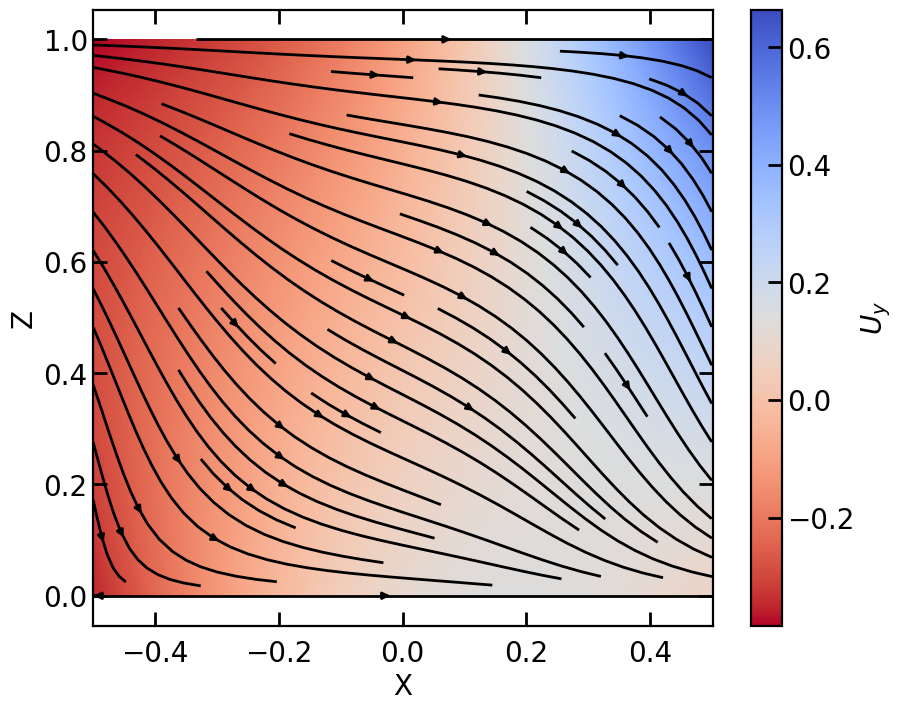

In [3]:
# testing symetric flow (should be same as above (and it is))
# x=np.linspace(-0.5,0.5,101)
# y=np.linspace(-0.5,0.5,101)
# z=np.linspace(0,1,101)
# t=np.arange(0,10,10)#1000

# a=0.62
# b=7.5
# c=0.69
# r0=0.5
# y0=0
# beta=0
# gamma=0
# epsilon=0
# sigma=0

x=np.linspace(-0.5,0.5,501)
y=np.linspace(-0.5,0.5,501)
z=np.linspace(0,1,501)
t=np.arange(0,10,10)#1000

a=0.62
b=7.5
c=0.69
r0=0.5
y0=0
beta=0
gamma=0
epsilon=0
sigma=0

T, X, Y, Z, ux, uy, uz = cylinder_flow3D(t,x,y,z,a,b,c,r0,y0,beta,gamma,epsilon, sigma) #t,z,y,x

fig,ax=plt.subplots()
ax.streamplot(X[0,:,50,:],Z[0,:,50,:],ux[0,:,50,:],uz[0,:,50,:],color='k')
pcm=ax.pcolormesh(X[0,:,50,:],Z[0,:,50,:],uy[0,:,50,:],cmap='coolwarm_r')#,vmin=-0.3,vmax=0.3)
ax.set_xlabel("X")
ax.set_ylabel("Z")
cbar=fig.colorbar(pcm,label='$U_{y}$')


## save to dataset
dset = xr.Dataset(
    data_vars=dict(U=(['time','depth','lat','lon'],ux),
                    V=(['time','depth','lat','lon'],uy),
                    W=(['time','depth','lat','lon'],uz)),
                    coords=dict(
                            time=t,
                            depth=('depth',z),
                            lon=('lon',x),
                            lat=('lat',y)
                    ),
                    attrs=dict(
                        title='symmeric 3D cylinder flow',
                        contact = 'm.f.bos@uu.nl')
    )
dset.to_netcdf(output_directory+'cylinder_flow_symmetric_3D_high_res.nc')


In [ ]:
dset = xr.Dataset(
    data_vars=dict(U=(['time','depth','lat','lon'],ux),
                    V=(['time','depth','lat','lon'],uy),
                    W=(['time','depth','lat','lon'],uz)),
                    coords=dict(
                            time=t,
                            depth=('depth',z),
                            lon=('lon',x),
                            lat=('lat',y)
                    ),
                    attrs=dict(
                        title='symmeric 3D cylinder flow',
                        contact = 'm.f.bos@uu.nl')
    )
dset.to_netcdf(output_directory+'cylinder_flow_symmetric_3D.nc')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


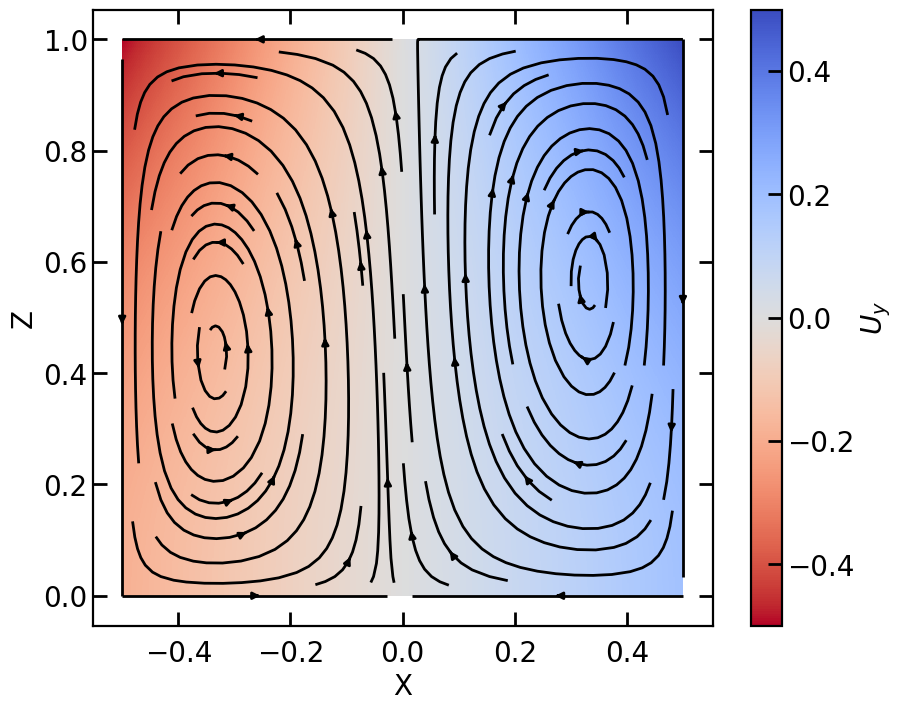

In [3]:
# steady assymetric flow
x=np.linspace(-0.5,0.5,501)
y=np.linspace(-0.5,0.5,501)
z=np.linspace(0,1,501)
t=np.arange(0,10,10)

a=0.62
b=7.5
c=0.69
r0=0.5
y0=-0.2
beta=0
gamma=0
epsilon=0.25
sigma=0

T, X, Y, Z, ux, uy, uz = cylinder_flow3D(t,x,y,z,a,b,c,r0,y0,beta,gamma,epsilon, sigma)

fig,ax=plt.subplots()
ax.streamplot(X[0,:,250,:],Z[0,:,250,:],ux[0,:,250,:],uz[0,:,250,:],color='k')
pcm=ax.pcolormesh(X[0,:,250,:],Z[0,:,250,:],uy[0,:,250,:],cmap='coolwarm_r')#,vmin=-0.3,vmax=0.3)
ax.set_xlabel("X")
ax.set_ylabel("Z")
cbar=fig.colorbar(pcm,label='$U_{y}$')

dset = xr.Dataset(
    data_vars=dict(U=(['time','depth','lat','lon'],ux),
                    V=(['time','depth','lat','lon'],uy),
                    W=(['time','depth','lat','lon'],uz)),
                    coords=dict(
                            time=t,
                            depth=('depth',z*1000),
                            lon=('lon',x*1000),
                            lat=('lat',y*1000)
                    ),
                    attrs=dict(
                        title='steady assymmeric 3D cylinder flow',
                        contact = 'm.f.bos@uu.nl')
    )
dset.to_netcdf(output_directory+'cylinder_flow_assymmetric_3D_large_scale.nc')


In [ ]:
# nonsteady assymetric
x=np.linspace(-0.5,0.5,101)
y=np.linspace(-0.5,0.5,101)
z=np.linspace(0,1,201)
t=np.arange(0,9.1,1)
print(y[50])
a=0.62
b=7.5
c=0.69
r0=0.5
y0=-0.2
beta=1
gamma=0.2
epsilon=0.25
sigma=2*np.pi/9.1


T, X, Y, Z, ux, uy, uz = cylinder_flow3D(t,x,y,z,a,b,c,r0,y0,beta,gamma,epsilon, sigma)
fig,ax=plt.subplots(2,2,figsize=(25,20))
n=0
m=0
for it in range(0,9,2):
    ax[m,n].streamplot(X[it,:,50,:],Z[it,:,50,:],ux[it,:,50,:],uz[it,:,50,:],color='k')
    pcm=ax[m,n].pcolormesh(X[it,:,50,:],Z[it,:,50,:],uy[it,:,50,:]-uy[0,:,50,:],cmap='coolwarm_r',vmin=-0.05,vmax=0.05)
    ax[m,n].set_xlabel("X")
    ax[m,n].set_ylabel("Z")
    ax[m,n].set_title('t={:.2f}'.format(t[it]),fontsize=20)
    n+=1
    if(n%2==0):
        m+=1
        n=0
cbar=fig.colorbar(pcm,ax=ax,label='$U_{y}(0)-U_{y}(t)$',shrink=0.6)

# dset = xr.Dataset(
#     data_vars=dict(U=(['time','depth','lat','lon'],ux),
#                     V=(['time','depth','lat','lon'],uy),
#                     W=(['time','depth','lat','lon'],uz)),
#                     coords=dict(
#                             time=t,
#                             depth=('depth',z),
#                             lon=('lon',x),
#                             lat=('lat',y)
#                     ),
#                     attrs=dict(
#                         title='periodic assymmeric 3D cylinder flow',
#                         contact = 'm.f.bos@uu.nl')
#     )
# dset.to_netcdf(output_directory+'cylinder_periodic_flow_assymmetric_3D_high_time_res.nc')


In [ ]:
it=9
fig,ax=plt.subplots()
ax.streamplot(X[it,:,50,:].T,Z[it,:,50,:].T,ux[it,:,50,:].T,uz[it,:,50,:].T,color='k')
pcm=ax.pcolormesh(X[it,:,50,:].T,Z[it,:,50,:].T,uy[it,:,50,:].T,cmap='coolwarm_r')#,vmin=-0.3,vmax=0.3)
ax.set_xlabel("X")
ax.set_ylabel("Z")
cbar=fig.colorbar(pcm,label='$U_{y}$')